In [1]:
# Guoqiang Tang
# Evaluate by reading metrics from statistical metrics
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import sys, glob, os, re, subprocess
import matplotlib
import matplotlib.pyplot as plt

def count_folders_in_directory(directory):
    return sum(os.path.isdir(os.path.join(directory, entry)) for entry in os.listdir(directory))


# Load Metrics

In [2]:
basins = []
for i in range(627):
    basins.append(f'level1_{i}')
    
# for i in range(40):
#     basins.append(f'level2_{i}')
    
# for i in range(4):
#     basins.append(f'level3_{i}')

In [3]:
# infiles
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich_m2err'
# infilelist_stat = glob.glob(f'{inpath}/level*_Ostrich/archive/PreserveBestModel/trial_stats_allrecords.txt')
# infilelist_stat.sort()
infilelist_stat = [f'{inpath}/{i}_OSTRICHcalib/archive/PreserveBestModel/trial_stats_allrecords.txt' for i in basins]
print('The number of stat files:', len(infilelist_stat))

# infilelist_ostmodel = glob.glob(f'{inpath}/level*_Ostrich/archive/PreserveBestModel/OstModel0.txt')
# infilelist_ostmodel.sort()
infilelist_ostmodel = [f'{inpath}/{i}_OSTRICHcalib/archive/PreserveBestModel/OstModel0.txt' for i in basins]
print('The number of OstModel0.txt files:', len(infilelist_stat))

The number of stat files: 627
The number of OstModel0.txt files: 627


In [4]:
# Metrics from OstModel0.txt
num = len(infilelist_ostmodel)
objfun = np.nan * np.zeros([num, 2]) # default param kge and best param kge

for i in range(num):
    infile_OstModel = infilelist_ostmodel[i]
    df_OstModel = pd.read_csv(infile_OstModel, delim_whitespace=True)
    df_OstModel['obj.function'] = df_OstModel['obj.function'].values.astype(float) # some times there is NaN string
    objfun[i, 0] = -df_OstModel['obj.function'].values[0]
    objfun[i, 1] = -df_OstModel['obj.function'].values[-1]

In [9]:
# Metrics from trial_stats_allrecords.txt

def read_trial_stats_allrecords(file_path):
    kge_values = []
    rmse_values = []
    m2err_values = []
    abserr_values = []
    maxmontherr_values = []
    
    with open(file_path, 'r') as file:
        for line in file:
            if '#streamflow_KGE' in line:
                kge_value = float(line.split('#')[0].strip())
                kge_values.append(kge_value)
            elif '#streamflow_RMSE' in line:
                rmse_value = float(line.split('#')[0].strip())
                rmse_values.append(rmse_value)
            elif '#streamflow_mean2err' in line:
                m2err_value = float(line.split('#')[0].strip())
                m2err_values.append(m2err_value)
            elif '#streamflow_abserr' in line:
                abserr_value = float(line.split('#')[0].strip())
                abserr_values.append(abserr_value)
            elif '#streamflow_maxmontherr' in line:
                maxmontherr_value = float(line.split('#')[0].strip())
                maxmontherr_values.append(maxmontherr_value)

    return np.array(kge_values), np.array(rmse_values), np.array(m2err_values), np.array(abserr_values), np.array(maxmontherr_values)

num = len(infilelist_ostmodel)
kge_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
rmse_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
m2err_stat = np.nan * np.zeros([num, 2])
abserr_stat = np.nan * np.zeros([num, 2])
maxmontherr_stat = np.nan * np.zeros([num, 2])

for i in range(num):
    infile_stat = infilelist_stat[i]
    tmpkge, tmprmse, tmpm2err, tmpabserr, tmpmontherr = read_trial_stats_allrecords(infile_stat)
    
    kge_stat[i, 0] = tmpkge[0]
    kge_stat[i, 1] = tmpkge[-1]
    
    rmse_stat[i, 0] = tmprmse[0]
    rmse_stat[i, 1] = tmprmse[-1]

    m2err_stat[i, 0] = tmpm2err[0]
    m2err_stat[i, 1] = tmpm2err[-1]

    abserr_stat[i, 0] = tmpabserr[0]
    abserr_stat[i, 1] = tmpabserr[-1]

    maxmontherr_stat[i, 0] = tmpmontherr[0]
    maxmontherr_stat[i, 1] = tmpmontherr[-1]


In [15]:
# check whether OstModel0.txt and trial_stats_allrecords.txt agree with each other
if np.any( np.abs(m2err_stat+objfun) > 1e-3):
    print('OstModel0.txt and trial_stats_allrecords.txt does not agree for some basins')
else:
    print('OstModel0.txt and trial_stats_allrecords.txt agree with each other for all basins')

OstModel0.txt and trial_stats_allrecords.txt agree with each other for all basins


# Load basin information

In [17]:
levelnum = []
basinnum = []
for f in infilelist_stat:
    matches = re.findall(r'level(\d+)_(\d+)_OSTRICHcalib', f)
    level, number = matches[0]
    levelnum.append(int(level))
    basinnum.append(int(number))

levelnum = np.array(levelnum)
basinnum = np.array(basinnum)

In [18]:
filesinfo = ['/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv', 
             '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/data_mesh_surf/HillslopeHydrology/CAMELS_level2_basin_info.csv',
             '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/data_mesh_surf/HillslopeHydrology/CAMELS_level3_basin_info.csv']

cols = ['hru_id', 'lon_cen', 'lat_cen', 'elev_mean', 'latoutlet', 'lonoutlet', 'areaUSGS']
basininfo = np.nan * np.zeros([num, len(cols)]) # lat, lon, areaUSGS
flag = 0
for i in range(1):
    dfi = pd.read_csv(filesinfo[i])
    basinnumi = basinnum[levelnum==i+1]
    for j in range(len(basinnumi)):
        basininfo[flag, :] = dfi.loc[basinnumi[j], cols].values
        flag = flag + 1

# Plot

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

## Plot iteration number

In [23]:
trialnum = [count_folders_in_directory(f'{inpath}/{i}_OSTRICHcalib/archive/PreserveModelOutput') for i in basins]
trialnum = np.array(trialnum)

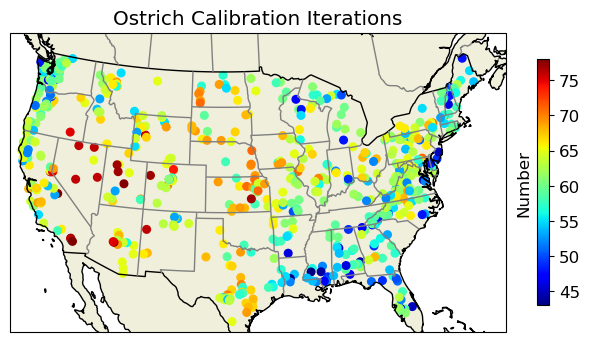

In [25]:
font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[8, 4])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(1, 1, 1, projection=proj)
ax = set_background(ax)
p = ax.scatter(basininfo[:,1], basininfo[:, 2], 30, trialnum, cmap='jet', transform=transf)
ax.set_title('Ostrich Calibration Iterations')
    
cax = plt.colorbar(p, ax=ax, label='Number', location='right', shrink=0.8)
cax.ax.yaxis.set_ticks_position('right')
cax.ax.yaxis.set_label_position('left')

# plt.savefig('Ostrich_iter_num.png', dpi=600, bbox_inches='tight', pad_inches=0)

## KGE map

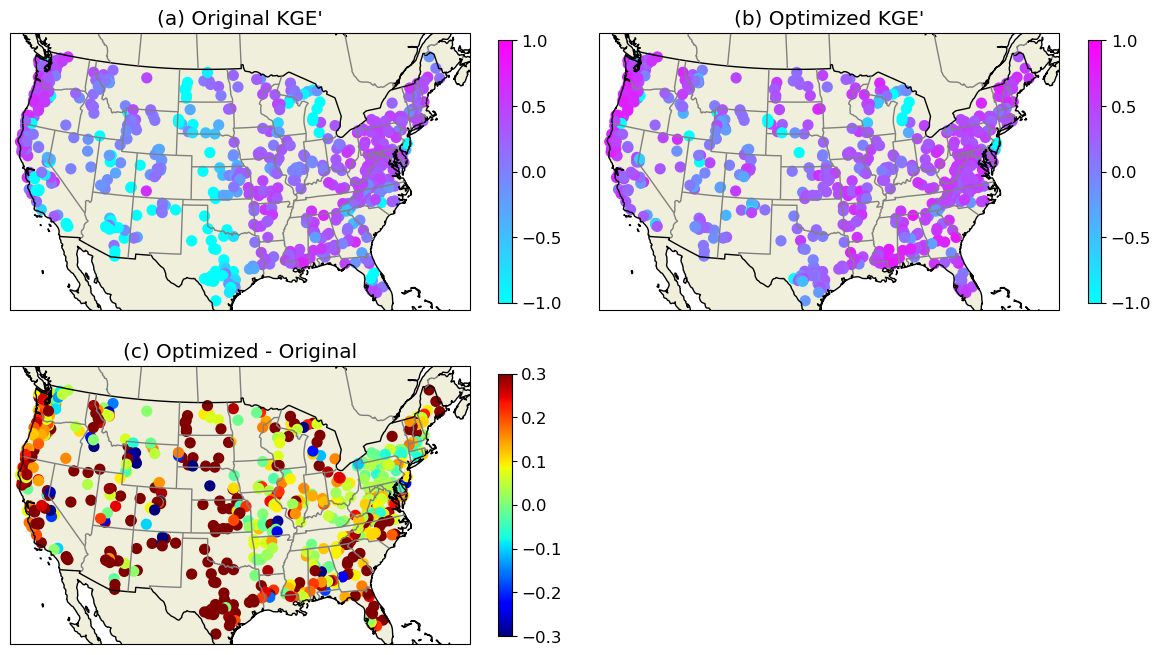

In [30]:
data = [kge_stat[:,0], kge_stat[:,1], kge_stat[:,1]-kge_stat[:,0]]
title = ["(a) Original KGE'", "(b) Optimized KGE'", "(c) Optimized - Original", "(d) Optimized - Original",]
cmaps = ['cool', 'cool', 'jet']
lims = [ [-1, 1], [-1, 1], [-0.3, 0.3]]


font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[12, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(basininfo[:,1], basininfo[:, 2], 50, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
# plt.savefig('CAMELS_calib_kge.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

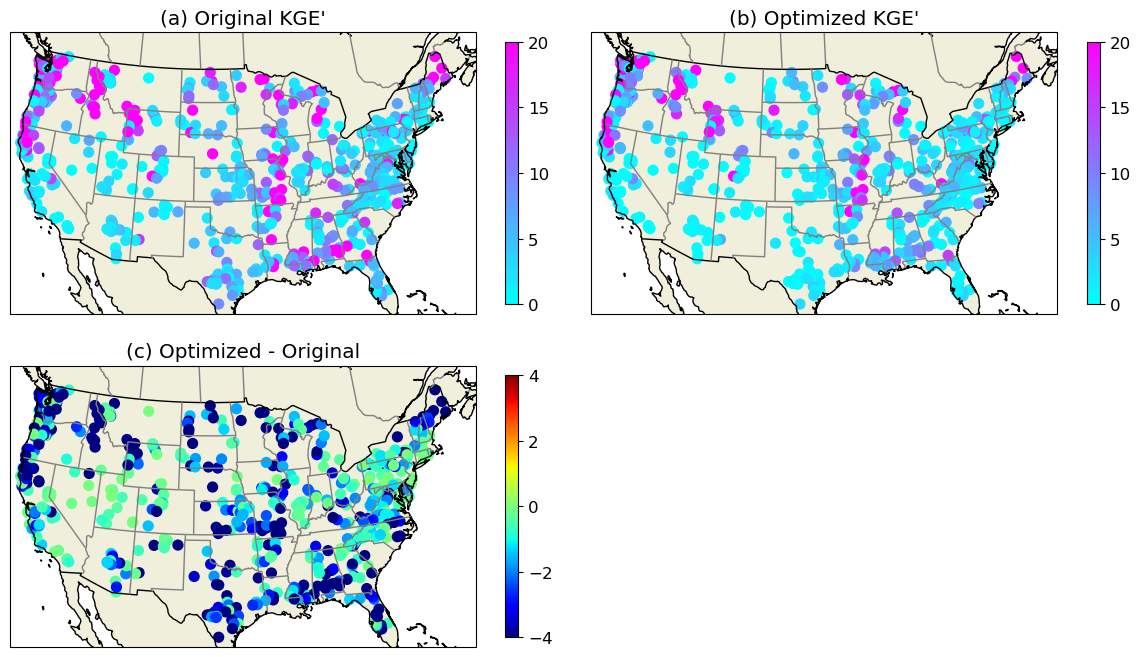

In [34]:
data = [m2err_stat[:,0], m2err_stat[:,1], m2err_stat[:,1]-m2err_stat[:,0]]
title = ["(a) Original KGE'", "(b) Optimized KGE'", "(c) Optimized - Original", "(d) Optimized - Original",]
cmaps = ['cool', 'cool', 'jet']
lims = [ [0, 20], [0, 20], [-4, 4]]


font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[12, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(basininfo[:,1], basininfo[:, 2], 50, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
# plt.savefig('CAMELS_calib_m2err.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()